# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


## Исследовательский анализ данных

__Целью__ данного проекта является создание модели которая помогла бы идентифицировать возраст человека на кассе магазина по лицу.

__Данные__ представлены в виде .jpeg файлов и таблицы разметки в .csv формате. Начнем анализ с разметки.

In [1]:
import os
import pandas as pd
from IPython.display import Image, display

In [2]:
markup = pd.read_csv('/datasets/faces/labels.csv')
markup.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Данные представлены в 2х столбцах: название файла и возраст. Взглянем на изображения.

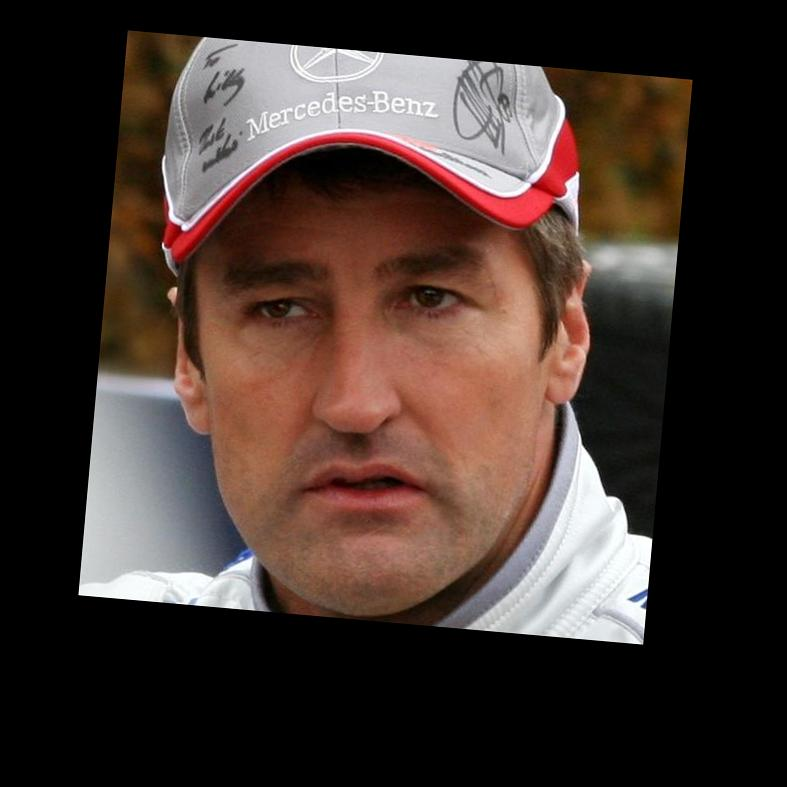

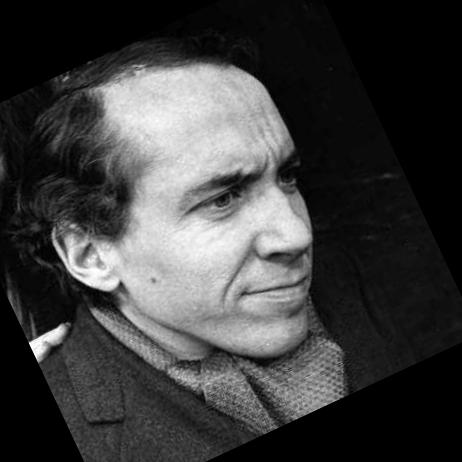

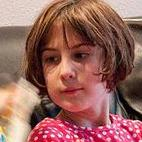

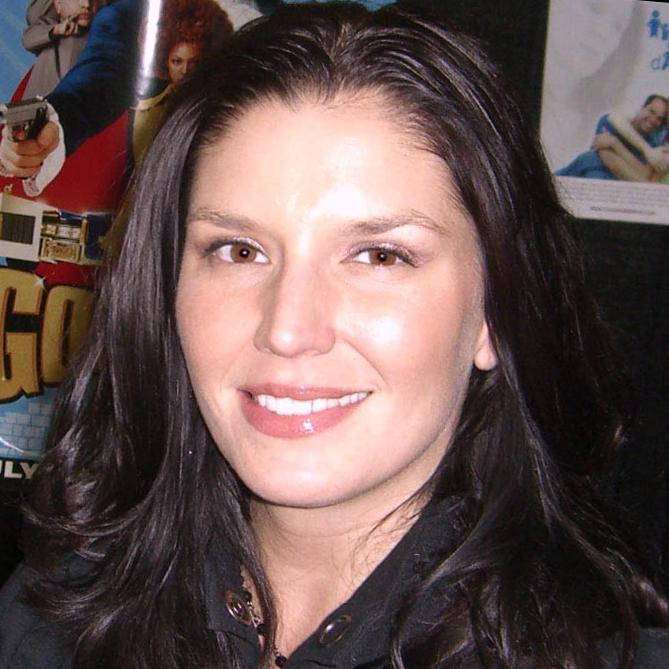

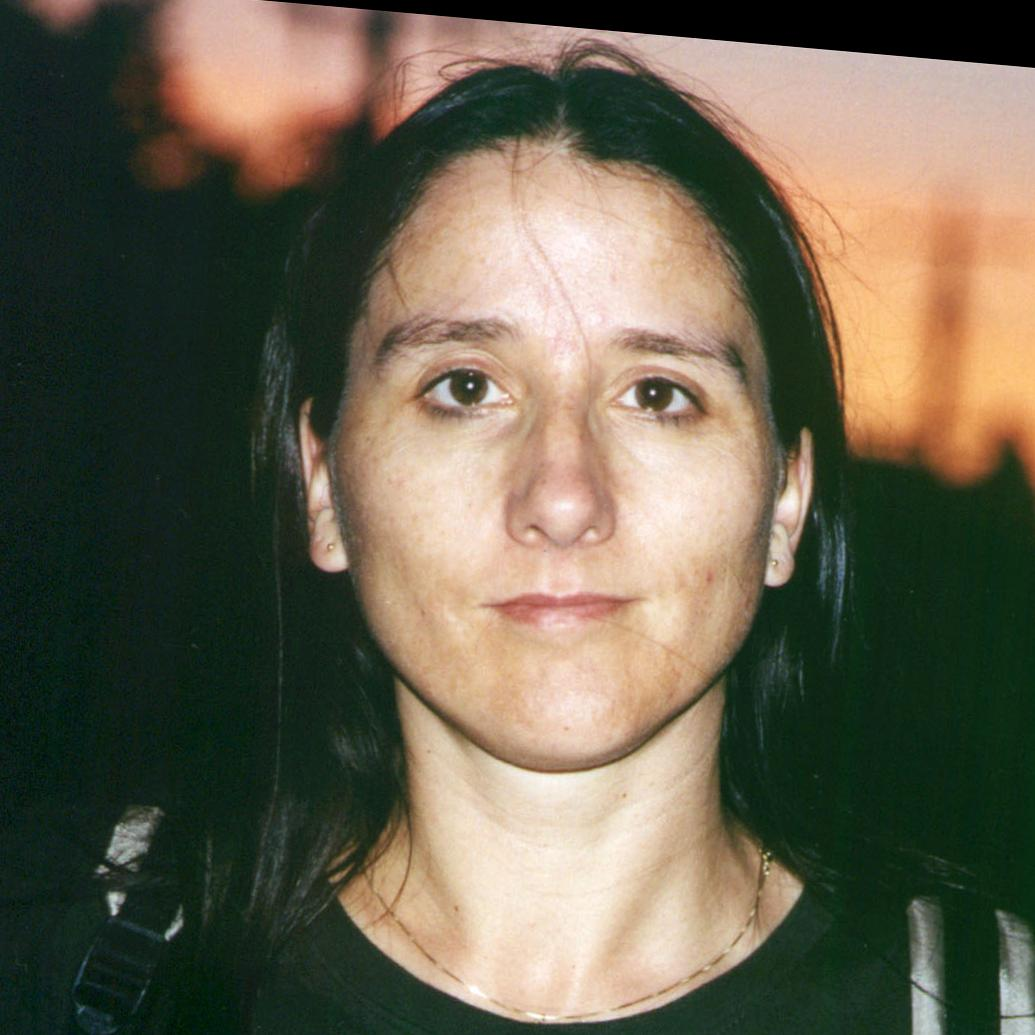

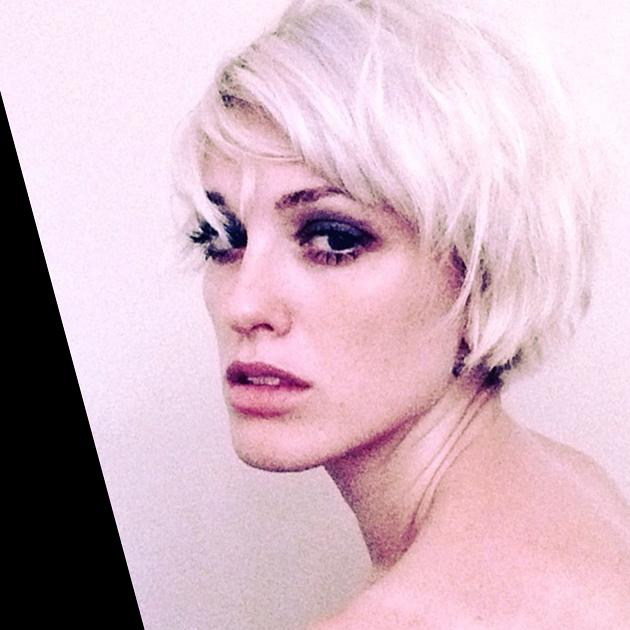

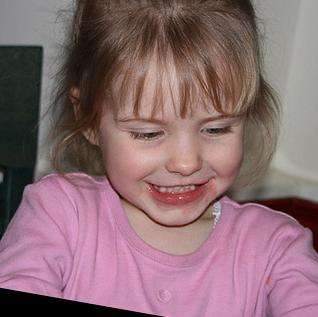

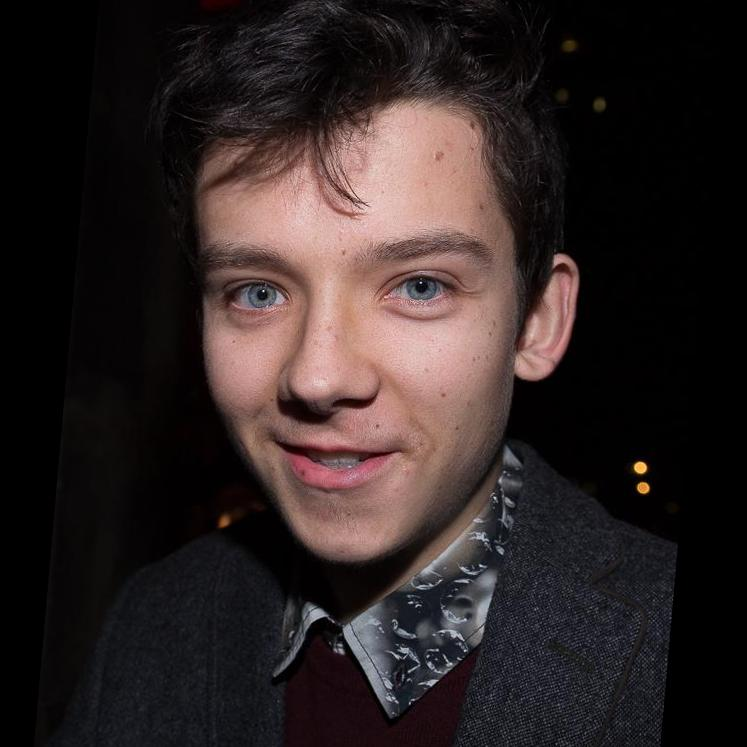

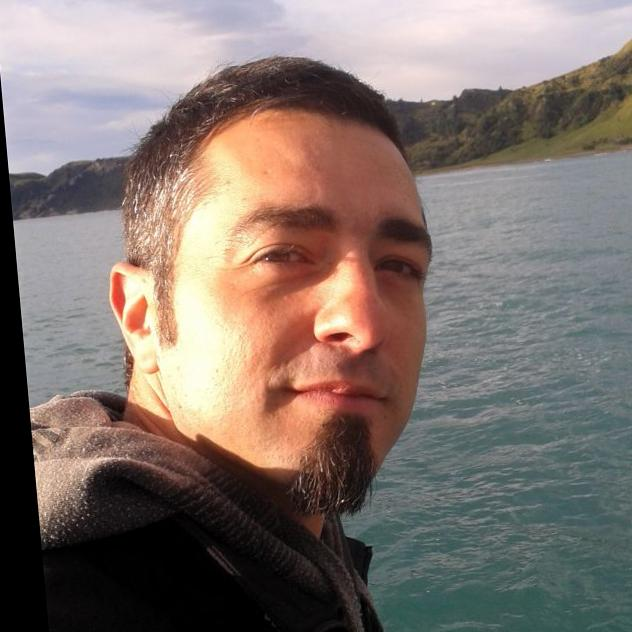

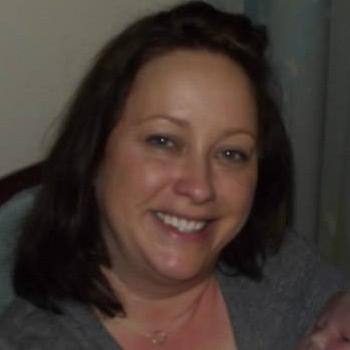

In [3]:
photo_directory = "/datasets/faces/final_files"
photos = os.listdir(photo_directory)
for photo in photos[:10]:
    display(Image(filename=os.path.join(photo_directory, photo)))

Сразу заметно что фото разного размера, сняты в разных условиях, с различным углом наклона. Есть также черно-белые фото.

Посмотрим есть ли дубликаты в названиях файлов.

In [4]:
markup[markup.file_name.duplicated()]

,file_name,real_age


Дубликатов по имени файла в таблице нет.

In [5]:
markup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропущенных значений нет, всего значений 7591, для такой сложной задачи как предсказание возраста этого не достаточно, например популярный датасет для определения возраста IMDB-WIKI содержит в себе пол миллиона фотографий. Проверим есть ли плохие значения в столбце real_age. 

In [6]:
markup.real_age.unique()

array([  4,  18,  80,  50,  17,  27,  24,  43,  26,  39,  51,   2,   1,
         6,   5,  40,  16,  29,  35,  25,  30,  65,  13,  28,  31,  10,
        34,  15,   8,  20,  19,  42,  23,  58,  44,   7,  21,  14,  48,
        45,  37,  22,  59,  53,   9,  41,  32,  60,  38,  54,  49,  36,
        11,  70,  52,  33,  72,  47,  46,  55,  63,  12,  56,   3,  68,
        64,  67,  62,  57,  75,  61,  69,  90,  85,  88,  73,  71,  83,
        84,  87,  66,  82,  86,  77, 100,  79,  78,  76,  94,  89,  74,
        97,  93,  81,  95,  96,  91])

Все значения числовые.

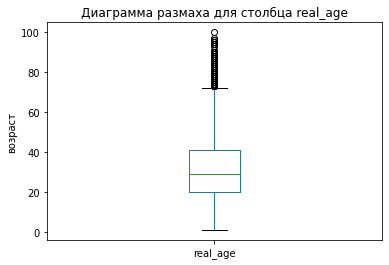

In [7]:
ax = markup.real_age.plot(
    kind='box', 
    title='Диаграмма размаха для столбца real_age',
    ylabel='возраст');

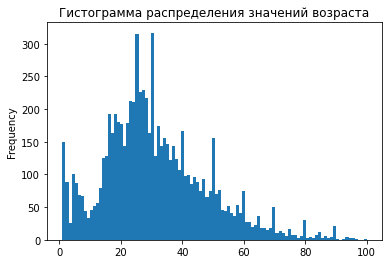

In [8]:
ax = markup.real_age.plot(
    kind='hist',
    bins=100,
    title='Гистограмма распределения значений возраста',
)

На гистограмме распределения возраста видно что данные представлены неравномерно, у распределения есть два горба. Один для детского возраста до 10 лет, с провалом в районе 3х лет, второй горб для молодых людей в возрасте около 25 лет. Больше всего в датасете именно людей в возрасте от 20 до 40 лет, людей после 60 очень мало. Такое распределение может оказать негативное влияние на обучение модели, так как она переобучится на людях среднего возраста и недообучится на старшем поколении.

__Вывод по EDA__: Датасет состоит из 7591 фотографии. Фотографии различаются по размеру, яркости, углу наклона и цветности. Дубликатов в данных нет, фотографий без указанного возраста в данных нет. Распреление возрастов не нормальное, небольшой пик для детей до 10 лет и основной пик для людей в возрасте от 20 до 40 лет. В гистограмме для некоторых возрастов присутствуют выбросы которые в 2-3 раза превышают соседние значения по частоте. Также в датасете очень мало людей старше 60 лет. Такое не равномерное распределение может негативно сказаться на предсказательных свойствах модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

__Исходный код модели__:
``` Python 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def load_train(path):
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=False,
        rescale=1/255.,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        shear_range=0.2,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_dataframe(
        pd.read_csv(f"{path}/labels.csv"),
        directory=f"{path}/final_files",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=1234
    )
    print('LOAD TRAIN')
    return train_generator

def load_test(path):
    test_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.2
    )

    test_generator = test_datagen.flow_from_dataframe(
        pd.read_csv(f"{path}/labels.csv"),
        directory=f"{path}/final_files",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation'
    )
    print('LOAD TEST')
    return test_generator

def create_model(input_shape):
    base_model = ResNet50(weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False, input_shape=input_shape)

    # Unfreeze the bottom layers of the model
    for layer in base_model.layers[:-20]:
        layer.trainable = True

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    learning_rate = 0.001

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])

    print('CREATE MODEL')
    return model

def train_model(model, train_generator, test_generator, epochs=20, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=validation_steps,
        shuffle=True,
        verbose=2
    )
    print('TRAIN MODEL')
    return model

# Example usage:
# train_generator = load_train('/path/to/train/data')
# test_generator = load_test('/path/to/test/data')
# model = create_model(input_shape=(224, 224, 3))
# trained_model = train_model(model, train_generator, test_generator, steps_per_epoch=100, validation_steps=50)
```


__Вывод консоли с сервера где обучалась модель__:
```
Found 6073 validated image filenames.
LOAD TRAIN
Found 1518 validated image filenames.
LOAD TEST
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/20
190/190 - 123s - loss: 283.5796 - mae: 12.9996 - val_loss: 288.0167 - val_mae: 13.2112
Epoch 2/20
190/190 - 114s - loss: 223.7552 - mae: 11.5939 - val_loss: 301.3071 - val_mae: 12.9834
Epoch 3/20
190/190 - 110s - loss: 197.8039 - mae: 10.8673 - val_loss: 330.2202 - val_mae: 13.4693
Epoch 4/20
190/190 - 110s - loss: 183.7960 - mae: 10.4177 - val_loss: 312.7437 - val_mae: 13.1471
Epoch 5/20
190/190 - 113s - loss: 181.6484 - mae: 10.2556 - val_loss: 460.7417 - val_mae: 15.5833
Epoch 6/20
190/190 - 114s - loss: 162.9492 - mae: 9.7393 - val_loss: 223.6304 - val_mae: 11.1378
Epoch 7/20
190/190 - 113s - loss: 156.5724 - mae: 9.5288 - val_loss: 270.0998 - val_mae: 13.2576
Epoch 8/20
190/190 - 114s - loss: 154.8725 - mae: 9.5063 - val_loss: 347.6446 - val_mae: 14.6076
Epoch 9/20
190/190 - 114s - loss: 156.0283 - mae: 9.5184 - val_loss: 215.6383 - val_mae: 10.8195
Epoch 10/20
190/190 - 114s - loss: 143.8534 - mae: 9.1918 - val_loss: 274.2621 - val_mae: 12.8901
Epoch 11/20
190/190 - 113s - loss: 139.2851 - mae: 8.9872 - val_loss: 169.2131 - val_mae: 9.7119
Epoch 12/20
190/190 - 109s - loss: 131.6414 - mae: 8.7783 - val_loss: 115.1324 - val_mae: 8.0350
Epoch 13/20
190/190 - 108s - loss: 131.2397 - mae: 8.6837 - val_loss: 123.8141 - val_mae: 8.5917
Epoch 14/20
190/190 - 108s - loss: 123.6190 - mae: 8.5102 - val_loss: 123.3311 - val_mae: 8.4455
Epoch 15/20
190/190 - 108s - loss: 126.2734 - mae: 8.5700 - val_loss: 222.9963 - val_mae: 11.0010
Epoch 16/20
190/190 - 108s - loss: 120.8308 - mae: 8.3676 - val_loss: 143.5689 - val_mae: 9.1790
Epoch 17/20
190/190 - 108s - loss: 121.1779 - mae: 8.3321 - val_loss: 163.3001 - val_mae: 9.3668
Epoch 18/20
190/190 - 108s - loss: 120.1632 - mae: 8.3184 - val_loss: 148.7052 - val_mae: 8.9095
Epoch 19/20
190/190 - 108s - loss: 112.7931 - mae: 8.0636 - val_loss: 157.2967 - val_mae: 9.9947
Epoch 20/20
190/190 - 108s - loss: 113.5284 - mae: 8.0821 - val_loss: 111.7722 - val_mae: 7.8604
TRAIN MODEL
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 111.7722 - mae: 7.8604
Test MAE: 7.8604
```

## Анализ обученной модели

__Вывод__:
Поставленого результата в MAE < 8 удалось достичь. Значение MAE на валидационной выборке составляет 7.8604, а на тренировочной 8.0821. Всего для достижения поставленой задачи понадобилось 20 итераций по всему датасету. Размер батча составил 32 изображения за 1 раз, в бэкбоне первые 30 слоёв обучались на данных, а последние 20 были заморожены. Что касается бизнес задачи то для неё адекватного решения нет, так как ошибка в 7.86 лет при продаж алкоголя и табака несовершеннолетним является неприемлимой. Возможно стоит подумать над альтернативными вариантами, к примеру фото лица + фото паспорта или паспорт с биометрией + отпечаток пальца.